In [ ]:
import torch
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from datasets import Dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df_clean = pd.read_csv('cleaned_tweets.csv', engine='python')

df_clean = df_clean.dropna(subset=['message', 'sentiment']).reset_index(drop=True)
df_clean = df_clean[df_clean['sentiment'] != 2].reset_index(drop=True)

train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42, stratify=df_clean['sentiment'])

sentiments = df_clean['sentiment'].unique().tolist()
sentiment2id = {sentiment: i for i, sentiment in enumerate(sentiments)}
id2sentiment = {i: sentiment for i, sentiment in enumerate(sentiments)}

train_df['sentiment_encoded'] = train_df['sentiment'].map(sentiment2id)
test_df['sentiment_encoded'] = test_df['sentiment'].map(sentiment2id)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
df_clean

,message,sentiment
0,@tiniebeany climate change is an interesting h...,-1
1,"Watch #BeforeTheFlood right here, as @LeoDiCap...",1
2,Fabulous! Leonardo #DiCaprio's film on #climat...,1
3,Just watched this amazing documentary by leona...,1
4,Leonardo DiCaprio's climate change documentary...,0
...,...,...
30305,#AikBaatSuniThi \nGlobal warming has negative ...,1
30306,"Dear @realDonaldTrump,\nYeah right. Human Medi...",1
30307,What will your respective parties do to preven...,1
30308,i still cant believe this gif of taehyung save...,0


In [ ]:
MODEL_NAME = "climatebert/distilroberta-base-climate-detector"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
  return tokenizer(examples['message'], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset = tokenized_train_dataset.remove_columns(['sentiment', 'message', '__index_level_0__'])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(['sentiment', 'message', '__index_level_0__'])
tokenized_train_dataset = tokenized_train_dataset.rename_column('sentiment_encoded', 'labels')
tokenized_test_dataset = tokenized_test_dataset.rename_column('sentiment_encoded', 'labels')


tokenized_train_dataset.set_format('torch')
tokenized_test_dataset.set_format('torch')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/24248 [00:00<?, ? examples/s]

Map:   0%|          | 0/6062 [00:00<?, ? examples/s]

In [ ]:
train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_test_dataset, shuffle=False, batch_size=16)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=len(sentiments),
    id2label=id2sentiment,
    label2id=sentiment2id
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True
).to(device)


optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

config.json:   0%|          | 0.00/887 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-detector and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(preds, labels):
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average="weighted")
  return {"accuracy": acc, "f1_score": f1}


best_accuracy = 0
output_dir = "./bertweet-finetuned-pytorch"
os.makedirs(output_dir, exist_ok=True)

for epoch in range(num_epochs):
  model.train()
  total_train_loss = 0
  progress_bar_train = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

  for batch in progress_bar_train:
    batch = {k: v.to(device) for k, v in batch.items()}
    optimizer.zero_grad()
    outputs = model(**batch)
    loss = outputs.loss
    total_train_loss += loss.item()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    progress_bar_train.set_postfix({'loss': loss.item()})

  avg_train_loss = total_train_loss / len(train_dataloader)
  print(f"Epoch {epoch+1} | Rata-rata Training Loss: {avg_train_loss:.4f}")

  model.eval()
  all_preds = []
  all_labels = []
  progress_bar_eval = tqdm(eval_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Evaluation]")

  with torch.no_grad():
    for batch in progress_bar_eval:
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1).cpu().numpy()
      labels_batch = batch['labels'].cpu().numpy()
      all_preds.extend(predictions)
      all_labels.extend(labels_batch)

  metrics = compute_metrics(np.array(all_preds), np.array(all_labels))
  print(f"Epoch {epoch+1} | Akurasi Validasi: {metrics['accuracy']:.4f} | F1 Validasi: {metrics['f1_score']:.4f}")

  if metrics['accuracy'] > best_accuracy:
    best_accuracy = metrics['accuracy']
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model terbaik baru disimpan dengan akurasi: {best_accuracy:.4f}")

print(f"Pelatihan selesai. Model terbaik disimpan di direktori: {output_dir}")

Epoch 1/3 [Training]:   0%|          | 0/1516 [00:00<?, ?it/s]

Epoch 1 | Rata-rata Training Loss: 0.6359


Epoch 1/3 [Evaluation]:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch 1 | Akurasi Validasi: 0.7700 | F1 Validasi: 0.7559
Model terbaik baru disimpan dengan akurasi: 0.7700


Epoch 2/3 [Training]:   0%|          | 0/1516 [00:00<?, ?it/s]

Epoch 2 | Rata-rata Training Loss: 0.4670


Epoch 2/3 [Evaluation]:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch 2 | Akurasi Validasi: 0.7870 | F1 Validasi: 0.7758
Model terbaik baru disimpan dengan akurasi: 0.7870


Epoch 3/3 [Training]:   0%|          | 0/1516 [00:00<?, ?it/s]

Epoch 3 | Rata-rata Training Loss: 0.3577


Epoch 3/3 [Evaluation]:   0%|          | 0/379 [00:00<?, ?it/s]

Epoch 3 | Akurasi Validasi: 0.7864 | F1 Validasi: 0.7782
Pelatihan selesai. Model terbaik disimpan di direktori: ./bertweet-finetuned-pytorch


In [ ]:
report = classification_report(all_labels, all_preds, target_names=[str(id2sentiment[i]) for i in sorted(id2sentiment.keys())])
print(report)

              precision    recall  f1-score   support

          -1       0.67      0.63      0.65       750
           1       0.83      0.91      0.87      3917
           0       0.68      0.52      0.59      1395

    accuracy                           0.79      6062
   macro avg       0.73      0.69      0.70      6062
weighted avg       0.78      0.79      0.78      6062



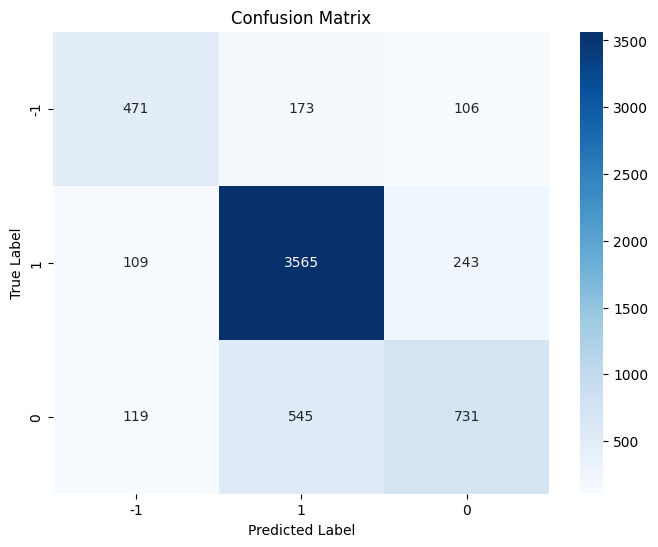

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
all_preds_np = np.array(all_preds)
all_labels_np = np.array(all_labels)

incorrect_indices = np.where(all_preds_np != all_labels_np)[0]

print(f"Number of incorrect predictions: {len(incorrect_indices)}")
print("\nExamples of incorrect predictions:")

num_examples_to_show = 10
for i in incorrect_indices[:num_examples_to_show]:
    original_text = test_df.iloc[i]['message']
    true_label_encoded = all_labels_np[i]
    predicted_label_encoded = all_preds_np[i]

    true_sentiment = id2sentiment[true_label_encoded]
    predicted_sentiment = id2sentiment[predicted_label_encoded]


    print(f"\nText: {original_text}")
    print(f"True Sentiment: {true_sentiment}, Predicted Sentiment: {predicted_sentiment}")

Number of incorrect predictions: 1295

Examples of incorrect predictions:

Text: @Libertea2012  The message continues the same, climate change is dangerous to our future, and world wide threat 2 all of us!
True Sentiment: 1, Predicted Sentiment: -1

Text: Corals are affected by lots of things. Imaginary man-made global warming is not one them.
True Sentiment: -1, Predicted Sentiment: 1

Text: 3Novices:Paris Climate Deal Weak, Unambitious: Centre For Science And Environment  The climate change agreement ado
True Sentiment: 0, Predicted Sentiment: 1

Text: Tomi's favorite hobby in 2016 was calling climate change 'bad weather.' But in 2014, she said it was an agreed-upon
True Sentiment: 1, Predicted Sentiment: 0

Text: Or global warming!
True Sentiment: -1, Predicted Sentiment: 0

Text: Invasive alien species are one of the biggest causes of biodiversity loss and species extinctions, but how is climate change comp
True Sentiment: 0, Predicted Sentiment: 1

Text: The same people who claime

In [ ]:
output_dir = "./bertweet-finetuned-pytorch"
loaded_tokenizer = AutoTokenizer.from_pretrained(output_dir)
loaded_model = AutoModelForSequenceClassification.from_pretrained(output_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model.to(device)

def predict_sentiment(text, model, tokenizer, device, id2sentiment):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    predicted_sentiment_id = predictions.item()
    predicted_sentiment = id2sentiment[predicted_sentiment_id]
    return predicted_sentiment

In [ ]:
climate_text = "Climate change is a serious issue and we need to take action now to protect our planet."
prediction = predict_sentiment(climate_text, loaded_model, loaded_tokenizer, device, id2sentiment)
print(f"Text: '{climate_text}'\nPrediction: {prediction}")

Text: 'Climate change is a serious issue and we need to take action now to protect our planet.'
Prediction: 1


In [ ]:
neutral_climate_text = "i think its okay"
prediction = predict_sentiment(neutral_climate_text, loaded_model, loaded_tokenizer, device, id2sentiment)
print(f"Text: '{neutral_climate_text}'\nPrediction: {prediction}")

Text: 'i think its okay'
Prediction: 0


In [ ]:
negative_climate_text = "Climate change is a hoax and a waste of resources."
prediction = predict_sentiment(negative_climate_text, loaded_model, loaded_tokenizer, device, id2sentiment)
print(f"Text: '{negative_climate_text}'\nPrediction: {prediction}")

Text: 'Climate change is a hoax and a waste of resources.'
Prediction: 1


In [ ]:
output_dir = "./bertweet-finetuned-distilroberta-base-climate-detector_CleanData"
zip_file_name = "/content/bertweet-finetuned-pytorch"

In [ ]:
!zip -r "{zip_file_name}.zip" "/content/bertweet-finetuned-pytorch"

  adding: content/bertweet-finetuned-pytorch/ (stored 0%)
  adding: content/bertweet-finetuned-pytorch/vocab.json (deflated 59%)
  adding: content/bertweet-finetuned-pytorch/added_tokens.json (deflated 65%)
  adding: content/bertweet-finetuned-pytorch/config.json (deflated 51%)
  adding: content/bertweet-finetuned-pytorch/merges.txt (deflated 53%)
  adding: content/bertweet-finetuned-pytorch/special_tokens_map.json (deflated 85%)
  adding: content/bertweet-finetuned-pytorch/model.safetensors (deflated 7%)
  adding: content/bertweet-finetuned-pytorch/tokenizer.json (deflated 82%)
  adding: content/bertweet-finetuned-pytorch/tokenizer_config.json (deflated 94%)


In [ ]:
!mv "{zip_file_name}.zip" "{output_dir}.zip"

mv: cannot stat '/content/bertweet-finetuned-pytorch.zip': No such file or directory


In [ ]:
from google.colab import files
import os

zip_file_path = os.path.join('/content', f"{output_dir}.zip")
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>